# Predict Car Price

Main focus on data modeling

## Import dependencies

In [1]:
import numpy as np
import math

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


### Get data
[Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)



* A comma separated file without a header row.  
* Provide a meaningful header name for the features.
* Really small dataset! Only 205 examples.




In [2]:
# Name the columns
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load the data
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv', sep=',', 
    names=feature_names, header=None, encoding='latin-1')


# Randomize the data
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))

Data set loaded. Num examples:  205


## Data modeling

* Handling small datasets: *Pandas*
* Feature transformations: *Tensorflow* Estimator and Feature Column APIs 
* Visualizations of transofrmations: *Matplotlib*

## Task 0: Explore and prepare the data

In [3]:
# Check few examples data
car_data[0:3]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,weight,engine-type,num-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
100,0,106,nissan,gas,std,four,sedan,fwd,front,97.20,173.40,65.20,54.70,2302,ohc,four,120,2bbl,3.33,3.47,8.50,97,5200,27,34,9549
25,1,148,dodge,gas,std,four,sedan,fwd,front,93.70,157.30,63.80,50.60,1989,ohc,four,90,2bbl,2.97,3.23,9.40,68,5500,31,38,6692
95,1,128,nissan,gas,std,two,hatchback,fwd,front,94.50,165.60,63.80,53.30,2028,ohc,four,97,2bbl,3.15,3.29,9.40,69,5200,31,37,7799


In [11]:
# State the label column name
LABEL = 'price'

# State the numeric and categotical features column names
numeric_feature_names = ['symboling','normalized-losses','wheel-base','length','width','height','weight','engine-size','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg']
categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

# Verify the segregation
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [12]:
# Inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg
100,0,106,97.20,173.40,65.20,54.70,2302,120,3.33,3.47,8.50,97,5200,27,34
25,1,148,93.70,157.30,63.80,50.60,1989,90,2.97,3.23,9.40,68,5500,31,38
95,1,128,94.50,165.60,63.80,53.30,2028,97,3.15,3.29,9.40,69,5200,31,37
145,0,102,97.00,172.00,65.40,54.30,2510,108,3.62,2.64,7.70,111,4800,24,29
55,3,150,95.30,169.00,65.70,49.60,2380,70,?,?,9.40,101,6000,17,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,1,113,93.10,166.80,64.20,54.10,1950,91,3.08,3.15,9.00,68,5000,31,38
123,-1,74,103.30,174.60,64.60,59.80,2535,122,3.35,3.46,8.50,88,5000,24,30
101,0,128,100.40,181.70,66.50,55.10,3095,181,3.43,3.27,9.00,152,5200,17,22
78,2,161,93.70,157.30,64.40,50.80,2004,92,2.97,3.23,9.40,68,5500,31,38


In [13]:
# Inspect categorical features.
car_data[categorical_feature_names]

,fuel-system,engine-type,fuel-type,num-cylinders,make,body-style,num-doors,drive-wheels,engine-location,aspiration
100,2bbl,ohc,gas,four,nissan,sedan,four,fwd,front,std
25,2bbl,ohc,gas,four,dodge,sedan,four,fwd,front,std
95,2bbl,ohc,gas,four,nissan,hatchback,two,fwd,front,std
145,mpfi,ohcf,gas,four,subaru,sedan,four,4wd,front,turbo
55,4bbl,rotor,gas,two,mazda,hatchback,two,rwd,front,std
...,...,...,...,...,...,...,...,...,...,...
54,2bbl,ohc,gas,four,mazda,sedan,four,fwd,front,std
123,2bbl,ohc,gas,four,plymouth,wagon,four,fwd,front,std
101,mpfi,ohcv,gas,six,nissan,sedan,four,fwd,front,std
78,2bbl,ohc,gas,four,mitsubishi,hatchback,two,fwd,front,std


In [14]:
# Coerce the numeric features to numbers make sure all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Initially Fill missing values with 0. NOTE: Not the best thing to do
car_data.fillna(0, inplace=True)

## Task 1: Make model with numeric features without normalization

* Required lowest eval loss
* Hyperparameters to be tunbed:
  - learning rate
  - choice of optimizer
  - hidden layer dimensions, based on the number of training examples
  - batch size
  - num training steps
  - (anything else you can think of changing)

In [19]:
# Set Hyperparameters
batch_size = 16
num_training_steps = 10000
num_print_statements = 10
learning_rate = 0.01
hidden_units = [64]

# Set the features and labels
X_train = car_data[numeric_feature_names]
y_train = car_data[LABEL]

# Create train, test and prediction functions: tf.estimator
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=X_train, y=y_train, batch_size=batch_size, num_epochs=None, shuffle=True)

test_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=X_train, y=y_train, batch_size=batch_size, shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=X_train, batch_size=batch_size, shuffle=False)

# Parse, preprocess features and create input layer: tf.feature_column
model_feature_columns = [tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names]
print('model_feature_columns', model_feature_columns)

# Create the model estimator: tf.estimator | AdagradOptimizer avoids NaN trainingloss
model_estimator = tf.estimator.DNNRegressor(feature_columns=model_feature_columns,
    hidden_units=hidden_units, optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate)) 

# TRAIN
for _ in range(num_print_statements):
  model_estimator.train(train_input_fn, steps=num_training_steps//num_print_statements)
  scores = model_estimator.evaluate(test_input_fn) 
  print('scores', scores)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='bore', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='stroke', shape=(1,), default_value=None, dtype=

### Visualize the model's predictions


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpvjfdrx3i/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


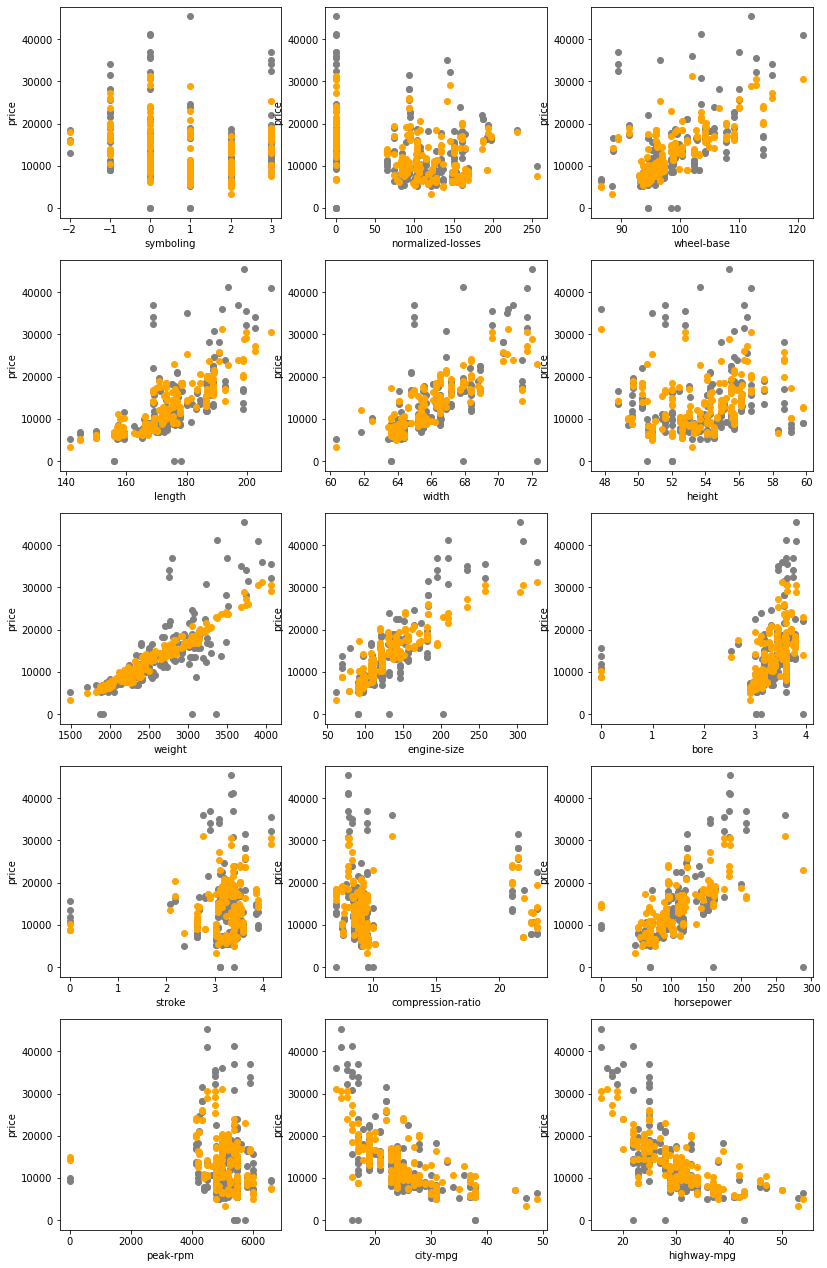

In [21]:
from matplotlib import pyplot as plt

def scatter_plot_inference_grid(est, x_df, feature_names):
  """Plots the predictions of the model against each feature.
  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create
      predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  def scatter_plot_inference(axis,
                             x_axis_feature_name,
                             y_axis_feature_name,
                             predictions):
    """Generate one subplot."""
    # Plot the real data in grey.
    y_axis_feature_name = 'price'
    axis.set_ylabel(y_axis_feature_name)
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name],
                 car_data[y_axis_feature_name],
                 c='grey')

    # Plot the predicted data in orange.
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

  predictions = [
    x['predictions'][0]
    for x in est.predict(predict_input_fn)
  ]
  
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names)/float(num_cols)))
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols*size, num_rows*size)
  
  for i, feature_name in enumerate(numeric_feature_names):
    axis = axarr[int(i/num_cols), i%num_cols]
    scatter_plot_inference(axis, feature_name, 'price', predictions)
  plt.show()

scatter_plot_inference_grid(model_estimator, X_train, numeric_feature_names)

## Task 2: Add normalization to the numeric model

- Normalize the numeric feature columns
- Retune the hyperparameters

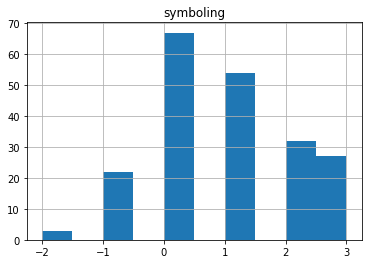

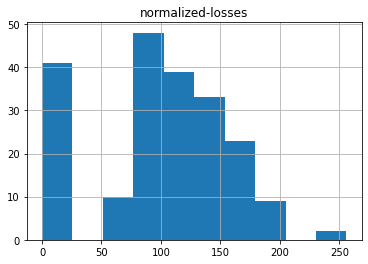

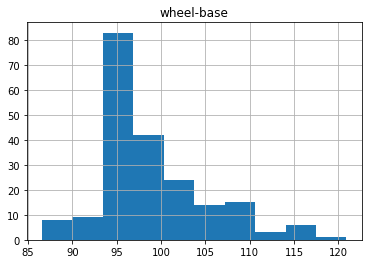

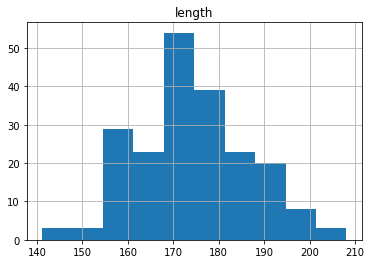

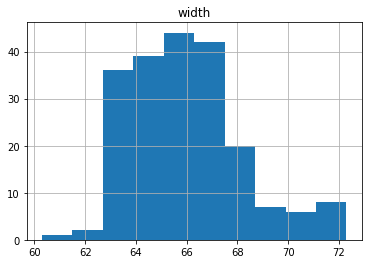

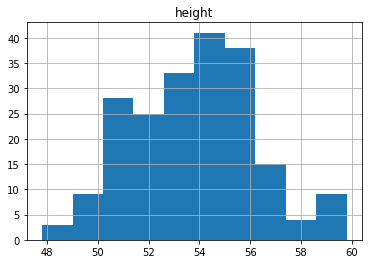

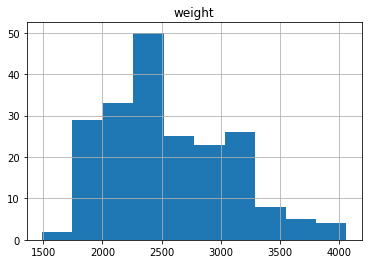

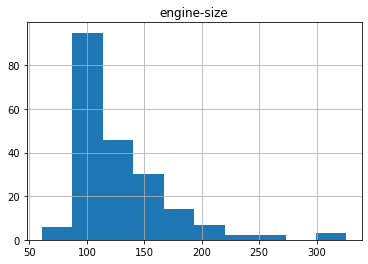

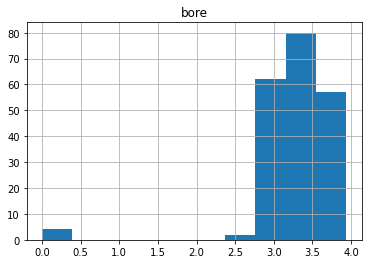

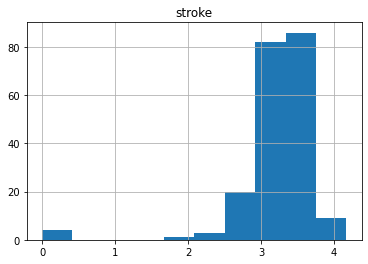

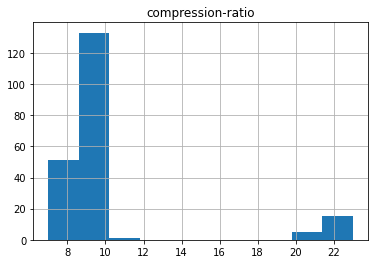

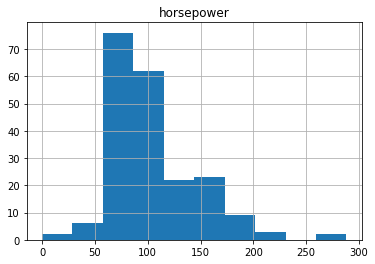

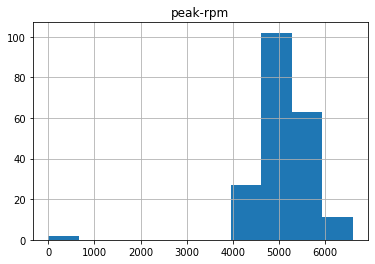

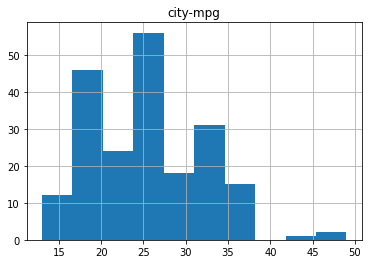

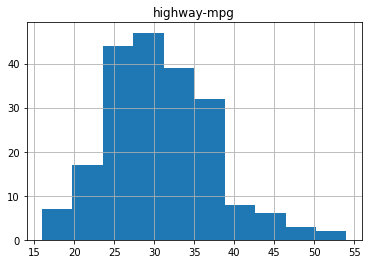

In [22]:
# Explore the features
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8ae23ad8c8>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8adcdfc510>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8adb835488>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8adb641950>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8adb641b70>), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7f8adca78620>), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function 

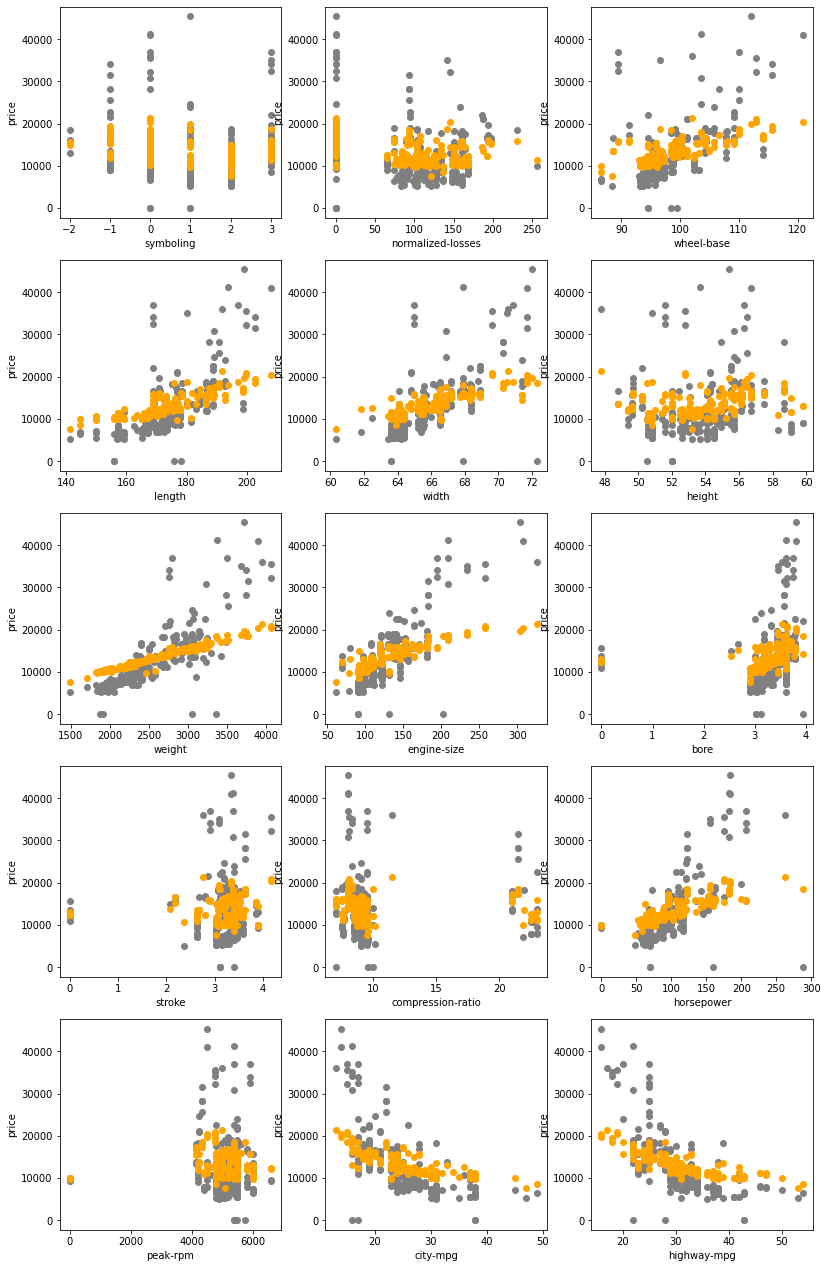

In [23]:
epsilon = 0.000001 # prevents divide by zero
batch_size = 16
num_print_statements = 10
num_training_steps = 10000
learning_rate=0.01
hidden_units=[64]

x_df = car_data[numeric_feature_names]
y_series = car_data[LABEL]

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# Z-score normalization since the distributions for most features looked roughly normally distributed.
model_feature_columns = [tf.feature_column.numeric_column(feature_name,
      normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name])) 
      for feature_name in numeric_feature_names]
print('model_feature_columns', model_feature_columns)

# Z-score normalization doesn't seem to be able to get SGD working
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=hidden_units,
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate),
)

# TRAIN
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  print('scores', scores)

scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make model using only categorical features


In [24]:
batch_size = 16
num_print_statements = 10
num_training_steps = 10000
hidden_units=[64]
learning_rate=0.01

x_df = car_data[categorical_feature_names]
y_series = car_data[LABEL]

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

# transform categorical features with vocabulary list
model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=hidden_units,
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate),
  )

# TRAIN
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('2bbl', 'mpfi', '4bbl', 'idi', 'spdi', '1bbl', 'spfi', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'ohcf', 'rotor', 'dohc', 'ohcv', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'two', 'six', 'twelve', 'five', 'eight', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('nissan', 'dodge', 'subaru', 'mazda', 'volkswagen'

## Task 4: Make model using all the features

In [26]:
epsilon = 0.000001
batch_size = 16
num_print_statements = 10
num_training_steps = 10000
hidden_units=[64]
learning_rate=0.01

x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data[LABEL]

train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False)

model_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique()))
    for feature_name in categorical_feature_names
] + [
    tf.feature_column.numeric_column(feature_name,
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=hidden_units,
    optimizer=tf.train.AdagradOptimizer(learning_rate=learning_rate),
  )

# TRAIN
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)
  print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('2bbl', 'mpfi', '4bbl', 'idi', 'spdi', '1bbl', 'spfi', 'mfi'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'ohcf', 'rotor', 'dohc', 'ohcv', 'l', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-type', vocabulary_list=('gas', 'diesel'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='num-cylinders', vocabulary_list=('four', 'two', 'six', 'twelve', 'five', 'eight', 'three'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('nissan', 'dodge', 'subaru', 'mazda', 'volkswagen'